In [2]:
import os, requests, zipfile
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter

# Download + unzip Text8
url = "http://mattmahoney.net/dc/text8.zip"
os.makedirs("data", exist_ok=True)
if not os.path.exists("data/text8"):
    with open("data/text8.zip", "wb") as f:
        f.write(requests.get(url).content)
    with zipfile.ZipFile("data/text8.zip", "r") as zip_ref:
        zip_ref.extractall("data")

# Tokenize and build vocab
with open("data/text8", "r") as f:
    words = f.read().split()
vocab_size = 30000
counts = Counter(words)
most_common = counts.most_common(vocab_size - 1)
word_to_index = {w: i + 1 for i, (w, _) in enumerate(most_common)}
word_to_index["<UNK>"] = 0
index_to_word = {i: w for w, i in word_to_index.items()}
indexed_words = [word_to_index.get(w, 0) for w in words]

# Dataset for Skip-gram
class SkipGramDataset(Dataset):
    def __init__(self, indexed_words, context_window):
        self.words = indexed_words
        self.window = context_window
    def __len__(self): return len(self.words)
    def __getitem__(self, idx):
        center = self.words[idx]
        start = max(0, idx - self.window)
        end = min(len(self.words), idx + self.window + 1)
        context = [self.words[i] for i in range(start, end) if i != idx]
        return [(center, c) for c in context]

# Collate function for Skip-gram
def collate_fn(batch):
    centers, contexts = [], []
    for pairs in batch:
        for c, ctx in pairs:
            centers.append(c)
            contexts.append(ctx)
    return torch.tensor(centers), torch.tensor(contexts)

# DataLoader
dataset = SkipGramDataset(indexed_words, context_window=2)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, collate_fn=collate_fn)


In [3]:
from torch import nn
embedding_dimension = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
center_word_embedding = nn.Embedding(vocab_size, embedding_dimension)
context_word_embedding = nn.Embedding(vocab_size, embedding_dimension)
center_word_embedding.weight.data.uniform_(-1 / (2 * embedding_dimension), 1 / (2 * embedding_dimension))
nn.init.constant_(context_word_embedding.weight, 0)


Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [4]:
from tqdm import tqdm
EPOCHS = 1
optimizer = torch.optim.Adam(list(center_word_embedding.parameters()) + list(context_word_embedding.parameters()), lr=0.001)
loss = nn.LogSigmoid()
word_frequency = torch.tensor([counts.get(index_to_word[i], 1) for i in range(vocab_size)], dtype=torch.float) ** 0.75
word_frequency /= word_frequency.sum()

for epoch in range(0, EPOCHS):
  for centers, contexts in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
    centers, contexts = centers.to(device), contexts.to(device)
    center_embeddings = center_word_embedding(centers)
    context_embeddings = context_word_embedding(contexts)
    positive_score = torch.sum(center_embeddings * context_embeddings, dim=1)
    batch_size = centers.shape[0]
    negative_embeddings = torch.multinomial(word_frequency, batch_size * 5, replacement=True).view(batch_size, 5)
    negative_embeddings = context_word_embedding(negative_embeddings)
    negative_scores = torch.bmm(negative_embeddings.neg(), center_embeddings.unsqueeze(2)).squeeze()
    negative_loss = loss(negative_scores).mean()
    positive_loss = loss(positive_score).mean()
    output = -1 * (positive_loss + negative_loss)
    optimizer.zero_grad()
    print(output)
    output.backward()
    optimizer.step()
  print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {output.item()}")


Epoch 1:   0%|          | 1/33214 [00:02<22:06:43,  2.40s/it]

tensor(1.3863, grad_fn=<MulBackward0>)
tensor(1.3863, grad_fn=<MulBackward0>)


Epoch 1:   0%|          | 3/33214 [00:02<5:55:30,  1.56it/s]

tensor(1.3863, grad_fn=<MulBackward0>)
tensor(1.3863, grad_fn=<MulBackward0>)


Epoch 1:   0%|          | 5/33214 [00:02<3:02:48,  3.03it/s]

tensor(1.3863, grad_fn=<MulBackward0>)
tensor(1.3862, grad_fn=<MulBackward0>)


Epoch 1:   0%|          | 5/33214 [00:03<6:10:04,  1.50it/s]


KeyboardInterrupt: 

In [9]:
from tqdm import tqdm
EPOCHS = 1
optimizer = torch.optim.Adam(list(center_word_embedding.parameters()) + list(context_word_embedding.parameters()), lr=0.001)
loss = nn.LogSigmoid()
word_frequency = torch.tensor([counts.get(index_to_word[i], 1) for i in range(vocab_size)], dtype=torch.float) ** 0.75
word_frequency /= word_frequency.sum()

for epoch in range(0, EPOCHS):
  for centers, contexts in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
    centers, contexts = centers.to(device), contexts.to(device)
    center_embeddings = center_word_embedding(centers)
    context_embeddings = context_word_embedding(contexts)
    positive_score = torch.sum(center_embeddings * context_embeddings, dim=1)
    batch_size = centers.shape[0]
    negative_embeddings = torch.multinomial(word_frequency, batch_size * 5, replacement=True).view(batch_size, 5)
    negative_embeddings = context_word_embedding(negative_embeddings)
    # negative_scores = torch.bmm(negative_embeddings.neg(), center_embeddings.unsqueeze(2)).squeeze()
    negative_scores = torch.bmm(negative_embeddings.neg(), center_embeddings.unsqueeze(2)).squeeze(2)
    # negative_loss = loss(negative_scores).mean()
    negative_loss = loss(negative_scores).sum(1)  # (B,) for K negatives per sample
    # positive_loss = loss(positive_score).mean()
    positive_loss = loss(positive_score)
    output = -(positive_loss + negative_loss).mean()
    # output = -1 * (positive_loss + negative_loss)
    optimizer.zero_grad()
    #print(output)
    output.backward()
    optimizer.step()
  print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {output.item()}")


Epoch 1: 100%|██████████| 33214/33214 [44:03<00:00, 12.56it/s]

Epoch 1/1, Loss: 2.1088435649871826


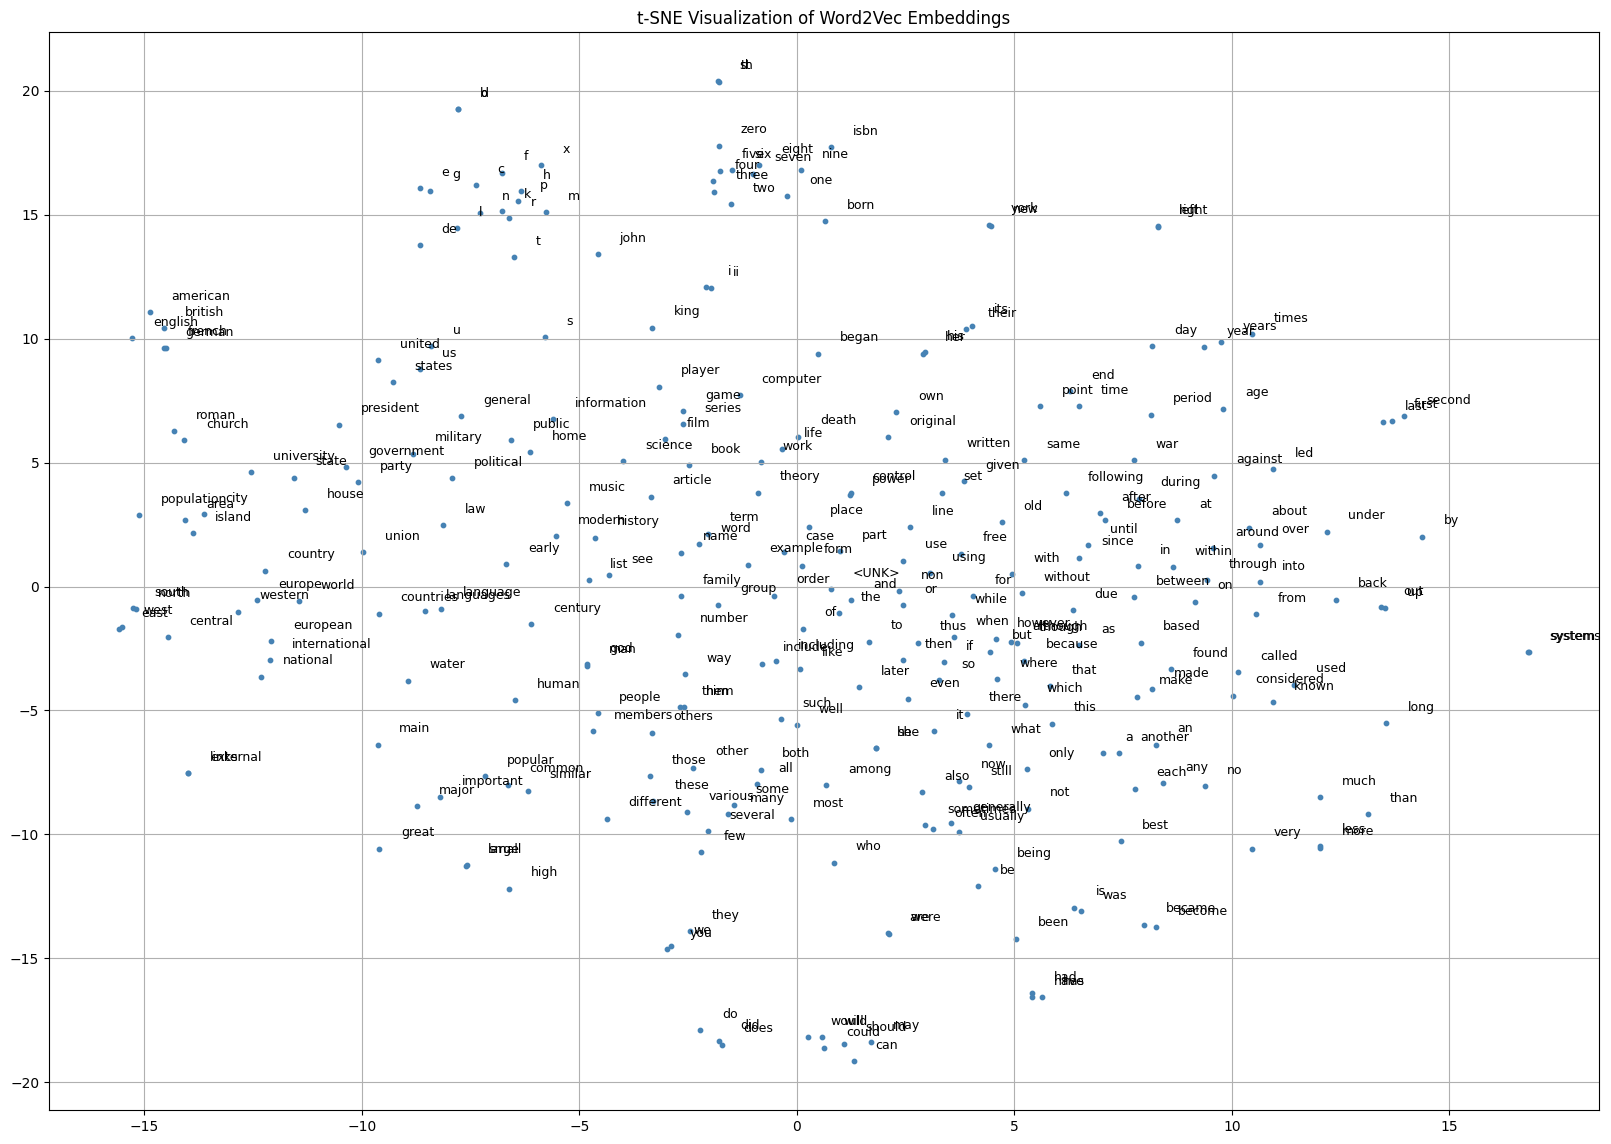

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
word_embeddings = center_word_embedding.weight.data.cpu().numpy()
num_words_to_visualize = 300
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_embeddings_2d = tsne.fit_transform(word_embeddings[:num_words_to_visualize])
plt.figure(figsize=(20, 14))
for i in range(num_words_to_visualize):
    plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1], s=10, color='steelblue')
    plt.text(word_embeddings_2d[i, 0]+0.5, word_embeddings_2d[i, 1]+0.5, index_to_word[i], fontsize=9)
plt.title("t-SNE Visualization of Word2Vec Embeddings")
plt.grid(True)
plt.show()

In [18]:
import torch.nn.functional as F
def find_analogy(target_word_a, target_word_b, reference_word, embedding_layer, word_to_index, index_to_word, top_k=2):
    vec_a = embedding_layer.weight[word_to_index[target_word_a]]
    vec_b = embedding_layer.weight[word_to_index[target_word_b]]
    vec_ref = embedding_layer.weight[word_to_index[reference_word]]
    analogy_vector = vec_b - vec_a + vec_ref
    all_embeddings = F.normalize(embedding_layer.weight.data, dim=1)
    analogy_vector = F.normalize(analogy_vector.unsqueeze(0), dim=1)
    cosine_similarities = torch.matmul(analogy_vector, all_embeddings.T).squeeze()
    for word in [target_word_a, target_word_b, reference_word]:
        cosine_similarities[word_to_index[word]] = -float('inf')
    top_indices = torch.topk(cosine_similarities, top_k).indices.tolist()
    return [index_to_word[i] for i in top_indices]
result = find_analogy("man", "woman", "king", center_word_embedding, word_to_index, index_to_word)
print(find_analogy("man", "woman", "king", center_word_embedding, word_to_index, index_to_word), find_analogy("us", "uk", "france", center_word_embedding, word_to_index, index_to_word))

['queen', 'elizabeth'] ['belgium', 'italy']
